In [271]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import leidenalg
import igraph as ig
import random
import numpy as np
import cdlib.algorithms
import bisect

## **0. Carga del grafo**

In [4]:
start = time.time()

G: nx.Graph = nx.read_graphml("hashtags_cleaned.graphml")

minutos, segundos = divmod(time.time()-start, 60)
print(f"****Tiempo de lectura: {int(minutos)} minutos y {segundos:.2f} segundos****")

****Tiempo de lectura: 0 minutos y 6.26 segundos****


### Subgrafo de prueba

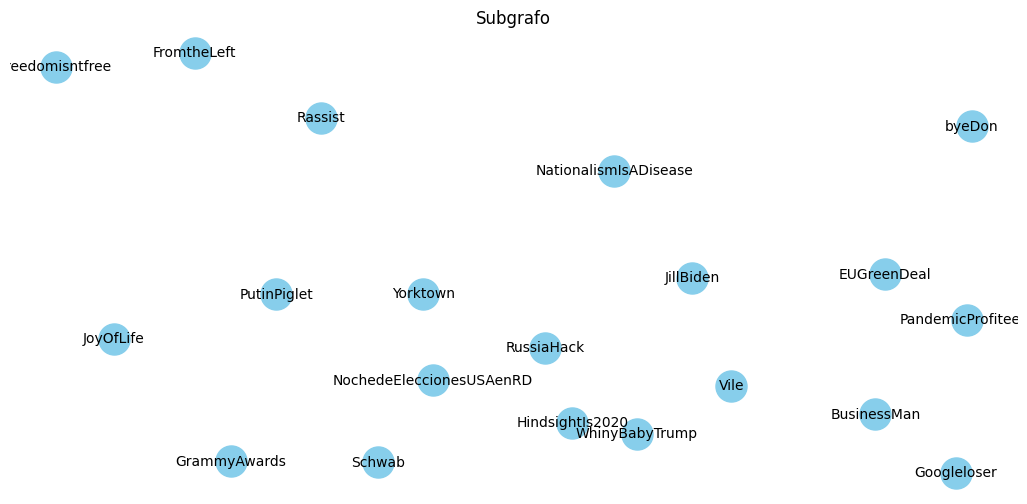

In [5]:
nodos_seleccionados = random.sample(sorted(G.nodes), k=20)

subgrafo = G.subgraph(nodos_seleccionados)
pos = nx.random_layout(subgrafo, seed=33)  # Puedes probar otros layouts como circular_layout

plt.figure(figsize=(13, 6))
nx.draw_networkx_nodes(subgrafo, pos, node_color='skyblue', node_size=500)

nx.draw_networkx_edges(subgrafo, pos, edge_color='red', width=2)
nx.draw_networkx_labels(subgrafo, pos, font_size=10, font_color="black")

plt.title("Subgrafo")
plt.axis("off")
plt.show()

## **1. Cálculo de comunidades**

In [6]:
leiden_comms = cdlib.algorithms.leiden(G).to_node_community_map()
nodes_dict = {k:v[0] for k,v in leiden_comms.items()} # 47544 nodes
communities = list(set(nodes_dict.values())) # n communities

for node in G.nodes: # Add community attribute to each node
    G.nodes[node]["community"] = nodes_dict[node]
for edge in G.edges:
    G.edges[edge]["weight"] = int(G.edges[edge]["weight"])
    
print("Número de comunidades:", len(communities))

Número de comunidades: 43


In [7]:
lista_num_nodos = [len([n for n in G.nodes if G.nodes[n]['community'] == i]) for i in communities]
print(lista_num_nodos[:10]) # comunidades ya ordenadas por número de nodos

[10235, 6773, 6415, 6006, 5033, 4839, 2444, 1793, 1265, 759]


## **2. Representación compacta**

In [8]:
for node in G.nodes:
    print(node, G.nodes[node])
    break
print("****")
for node in G.nodes(data=True):
    print(node)
    break
print("****")
print(G.nodes["Spain"])

Υστερογραφα {'community': 3}
****
('Υστερογραφα', {'community': 3})
****
{'community': 6}


In [9]:
for edge in G.edges:
    print(edge, G.edges[edge])
    break 
print("****")
for edge in G.edges(data=True):
    print(edge)
    break 

('Υστερογραφα', 'Trump') {'weight': 14}
****
('Υστερογραφα', 'Trump', {'weight': 14})


---

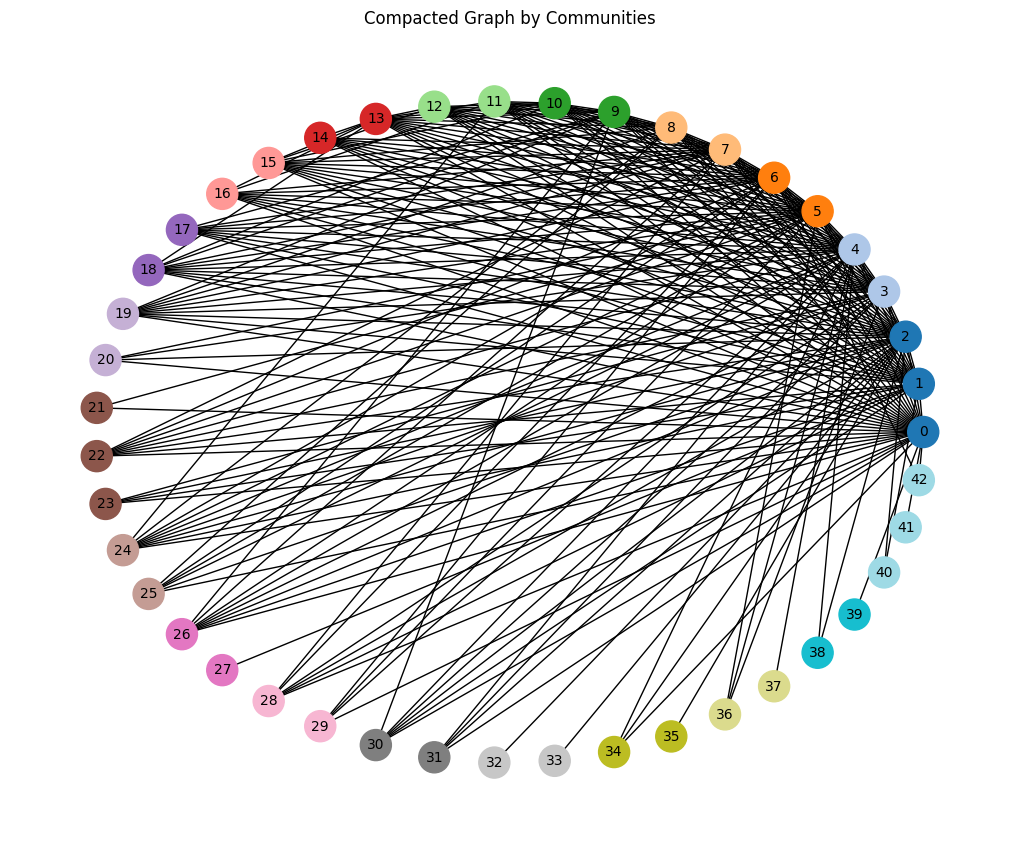

In [10]:
compact_graph = nx.Graph()

for community in communities:
    compact_graph.add_node(community)

for node in compact_graph.nodes():
    compact_graph.nodes[node]['size'] = lista_num_nodos[node]

for u, v in G.edges():
    community_u = nodes_dict[u]
    community_v = nodes_dict[v]
    if community_u != community_v:  # Only add edges between different communities
        if compact_graph.has_edge(community_u, community_v):
            compact_graph[community_u][community_v]['weight'] += G.edges[u, v]['weight']
        else:
            compact_graph.add_edge(community_u, community_v, weight=G.edges[u, v]['weight'])

# Assign a different color to each node
# node_colors = plt.cm.tab20(np.linspace(0, 1, len(communities)))
node_colors = plt.cm.get_cmap("tab20")(np.linspace(0, 1, len(communities)))

# plt.figure(figsize=(15, 12))
plt.figure(figsize=(10, 8))
pos = nx.circular_layout(compact_graph)
nx.draw(compact_graph, pos, with_labels=True, node_size=500, font_size=10, node_color=node_colors)
plt.title("Compacted Graph by Communities")
plt.show()

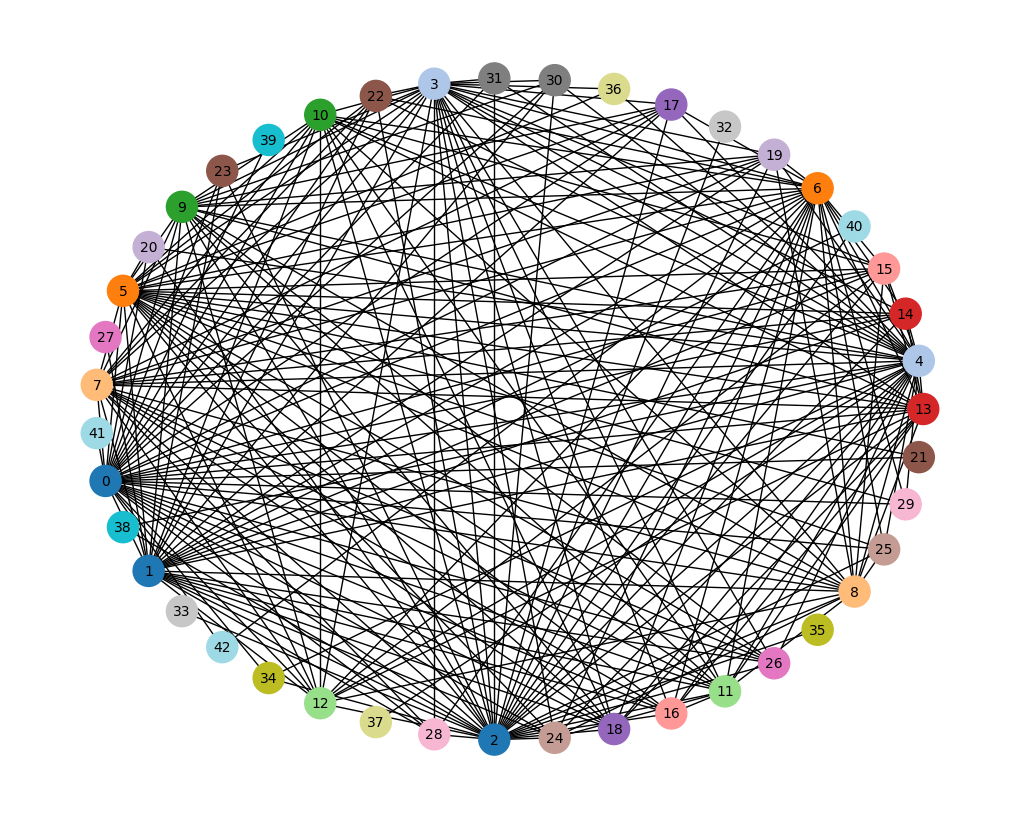

In [11]:
compact_graph = nx.Graph()

for community in communities:
    compact_graph.add_node(community)

for node in compact_graph.nodes():
    compact_graph.nodes[node]['size'] = lista_num_nodos[node]

for u, v in G.edges():
    community_u = nodes_dict[u]
    community_v = nodes_dict[v]
    if community_u != community_v:  # Only add edges between different communities
        if compact_graph.has_edge(community_u, community_v):
            compact_graph[community_u][community_v]['weight'] += G.edges[u, v]['weight']
        else:
            compact_graph.add_edge(community_u, community_v, weight=G.edges[u, v]['weight'])

nodes = list(compact_graph.nodes())
random.shuffle(nodes)

# Create a circular layout with randomized nodes
pos = {}
theta = np.linspace(0, 2 * np.pi, len(nodes), endpoint=False)  # Equally spaced angles
for node, angle in zip(nodes, theta):
    pos[node] = (np.cos(angle), np.sin(angle))  # Position each node on the circle

node_colors = plt.cm.get_cmap("tab20")(np.linspace(0, 1, len(nodes)))

plt.figure(figsize=(10, 8))
nx.draw(compact_graph, pos, with_labels=True, node_size=500, font_size=10, node_color=node_colors)
plt.show()

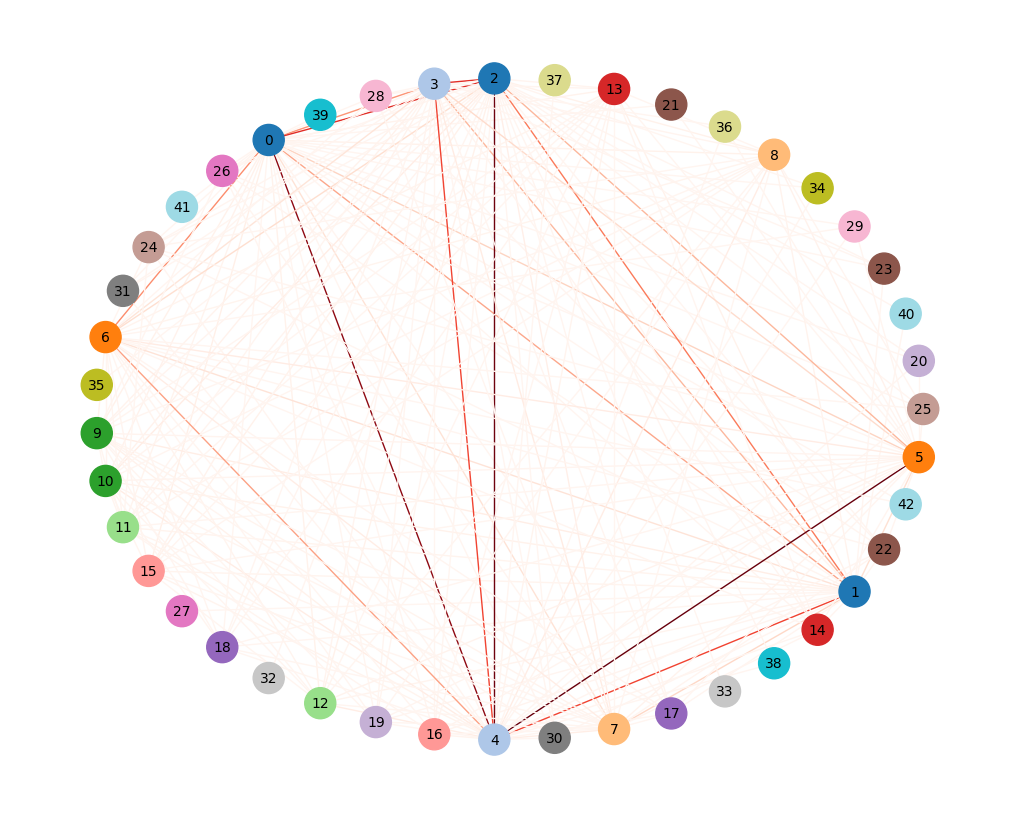

In [12]:
compact_graph = nx.Graph()

for community in communities:
    compact_graph.add_node(community)

for node in compact_graph.nodes():
    compact_graph.nodes[node]['size'] = lista_num_nodos[node]

for u, v in G.edges():
    community_u = nodes_dict[u]
    community_v = nodes_dict[v]
    if community_u != community_v:  # Only add edges between different communities
        if compact_graph.has_edge(community_u, community_v):
            compact_graph[community_u][community_v]['weight'] += G.edges[u, v]['weight']
        else:
            compact_graph.add_edge(community_u, community_v, weight=G.edges[u, v]['weight'])

nodes = list(compact_graph.nodes())
random.shuffle(nodes)

#normalize edge weights
max_weight = max([compact_graph.edges[e]["weight"] for e in compact_graph.edges])
min_weight = min([compact_graph.edges[e]["weight"] for e in compact_graph.edges])
for e in compact_graph.edges:
    compact_graph.edges[e]["weight"] = (compact_graph.edges[e]["weight"] - min_weight) / (max_weight - min_weight)

# Create a circular layout with randomized nodes
pos = {}
theta = np.linspace(0, 2 * np.pi, len(nodes), endpoint=False)  # Equally spaced angles
for node, angle in zip(nodes, theta):
    pos[node] = (np.cos(angle), np.sin(angle))  # Position each node on the circle

node_colors = plt.cm.get_cmap("tab20")(np.linspace(0, 1, len(nodes)))

plt.figure(figsize=(10, 8))
nx.draw(compact_graph, pos, with_labels=True, node_size=500, font_size=10, 
        node_color=node_colors, 
        edge_color=[compact_graph.edges[e]["weight"] for e in compact_graph.edges], 
        edge_cmap=plt.cm.get_cmap("Reds"))
plt.show()

In [13]:
print(compact_graph.get_edge_data(0, 1)) # 0 and 1 are the community nodes

{'weight': 0.31103996032411696}


## **3. Métricas de comunidades**

### **Modularidad**

In [14]:
G_igraph = ig.Graph.from_networkx(G)
partitions = []
modularities = []
for i in range(10):
    partition = leidenalg.find_partition(G_igraph, leidenalg.ModularityVertexPartition)
    partitions.append(len(partition))
    modularities.append(round(partition.modularity, ndigits=3))

print(f"Nº comunidades: {partitions}")
print(f"Modularidades: {modularities}")

Nº comunidades: [64, 64, 56, 56, 71, 35, 35, 44, 44, 40]
Modularidades: [0.412, 0.412, 0.414, 0.414, 0.4, 0.405, 0.405, 0.413, 0.413, 0.412]


### **Tamaño de comunidades**

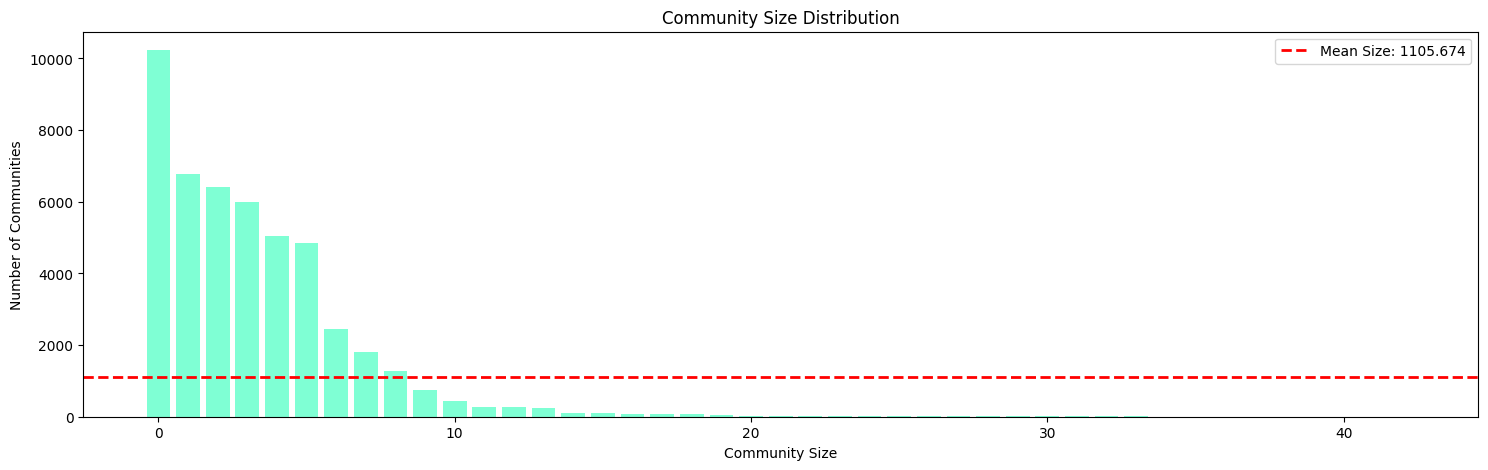

In [26]:
mean_size = np.mean(lista_num_nodos)

plt.figure(figsize=(18, 5))
plt.bar(communities, lista_num_nodos, color='aquamarine')
plt.axhline(mean_size, color='red', linestyle='--', linewidth=2, label=f'Mean Size: {mean_size:.3f}')
plt.xlabel("Community Size")
plt.ylabel("Number of Communities")
plt.title("Community Size Distribution")
plt.legend()
plt.show()

### **Densidad de comunidades**

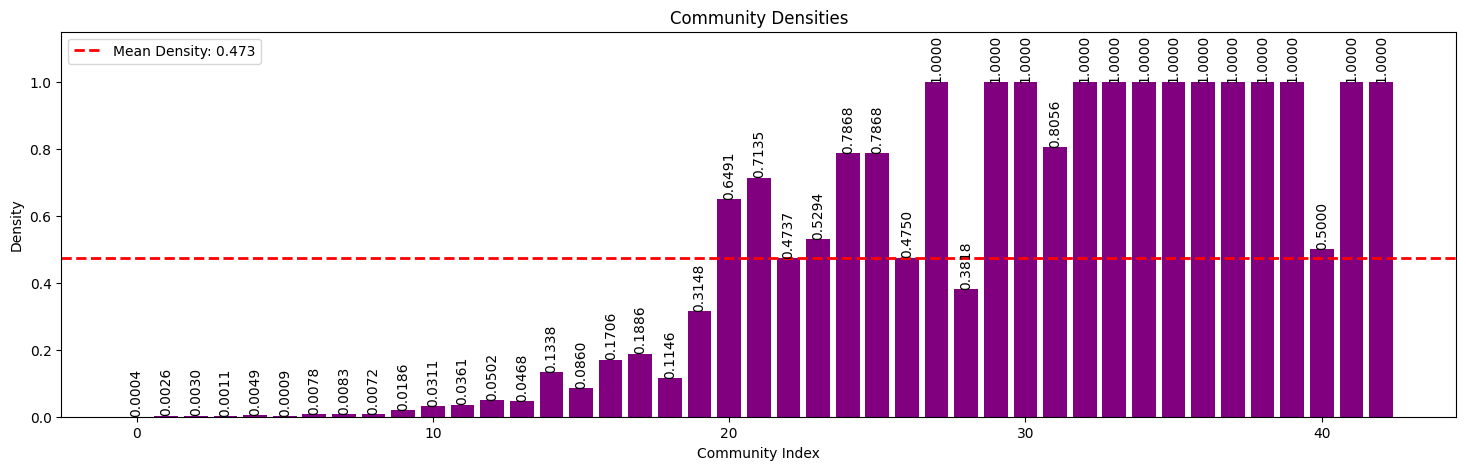

In [245]:
densities = []
for com_index in communities:
    community_nodes = [node for node, comm in nodes_dict.items() if comm == com_index]
    community_subgraph: nx.Graph = G.subgraph(community_nodes)
    num_nodes = community_subgraph.number_of_nodes()
    num_edges = community_subgraph.number_of_edges()
    if num_nodes <= 1:
        pass  # Avoid division by zero for single-node communities
    density = 2 * num_edges / (num_nodes * (num_nodes - 1))
    densities.append(density)

# ----------------------------------
mean_density = np.mean(densities)
plt.figure(figsize=(18, 5))
bars = plt.bar(communities, densities, color='purple')

# Add density values above each bar
for bar, density in zip(bars, densities):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate: Center of the bar
        bar.get_height(),                  # Y-coordinate: Top of the bar
        f'{density:.4f}',                  
        ha='center',                       
        va='bottom',                       
        rotation=90,                      
        fontsize=10                        
    )

# Adjust ylim to give extra space
plt.ylim(0, max(densities) + 0.15)

plt.axhline(mean_density, color='red', linestyle='--', linewidth=2, label=f'Mean Density: {mean_density:.3f}')
plt.xlabel('Community Index')
plt.ylabel('Density')
plt.title('Community Densities')
plt.legend()
plt.show()

### **Conductancia de comunidades**

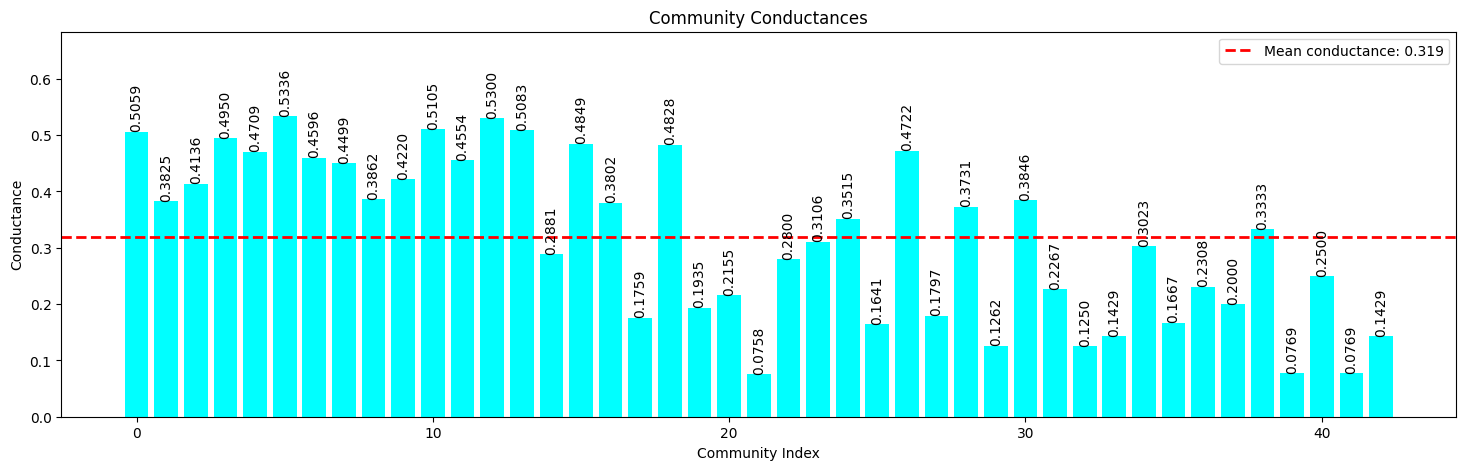

In [246]:
def community_conductance(graph: nx.Graph, community_nodes):
    """Compute the conductance of a community."""
    internal_edges = 0
    boundary_edges = 0

    for node in community_nodes:
        for neighbor in graph.neighbors(node):
            if neighbor in community_nodes:
                internal_edges += 1
            else:
                boundary_edges += 1

    total_edges = internal_edges + boundary_edges
    if total_edges == 0:
        return 1  # Fully disconnected community
    return boundary_edges / total_edges

conductances = []
for com_index in communities:
    community_nodes = [node for node, comm in nodes_dict.items() if comm == com_index]
    conductance = community_conductance(G, community_nodes)
    conductances.append(conductance)

# ----------------------------------
mean_conductance = np.mean(conductances)
plt.figure(figsize=(18, 5))
bars = plt.bar(communities, conductances, color='cyan')

for bar, conductance in zip(bars, conductances):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate: Center of the bar
        bar.get_height(),                  # Y-coordinate: Top of the bar
        f'{conductance:.4f}',                  
        ha='center',                       
        va='bottom',                       
        rotation=90,                      
        fontsize=10                        
    )

plt.ylim(0, max(conductances) + 0.15)

plt.axhline(mean_conductance, color='red', linestyle='--', linewidth=2, label=f'Mean conductance: {mean_conductance:.3f}')
plt.xlabel('Community Index')
plt.ylabel('Conductance')
plt.title('Community Conductances')
plt.legend()
plt.show()

### **Cobertura de comunidades**

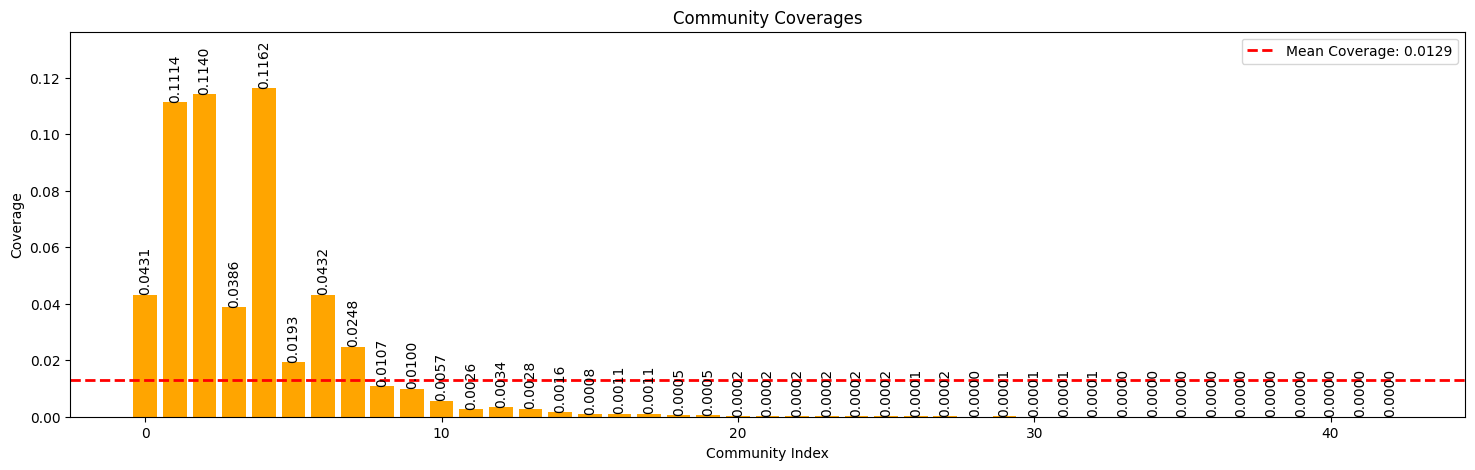

In [247]:
coverages = []
total_edges = G.number_of_edges()
for com_index in communities:
    community_nodes = [node for node, comm in nodes_dict.items() if comm == com_index]
    community_subgraph: nx.Graph = G.subgraph(community_nodes)
    internal_edges = community_subgraph.number_of_edges()
    coverage = internal_edges / total_edges
    coverages.append(coverage)

# Plot the community coverages
mean_coverage = np.mean(coverages)
plt.figure(figsize=(18, 5))
bars = plt.bar(communities, coverages, color='orange')

# Add coverage values above each bar
for bar, coverage in zip(bars, coverages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate: Center of the bar
        bar.get_height(),                  # Y-coordinate: Top of the bar
        f'{coverage:.4f}',                  
        ha='center',                       
        va='bottom',                       
        rotation=90,                      
        fontsize=10                        
    )

plt.ylim(0, max(coverages) + 0.02)
plt.axhline(mean_coverage, color='red', linestyle='--', linewidth=2, label=f'Mean Coverage: {mean_coverage:.4f}')
plt.xlabel('Community Index')
plt.ylabel('Coverage')
plt.title('Community Coverages')
plt.legend()
plt.show()

### **Entropía de comunidades**

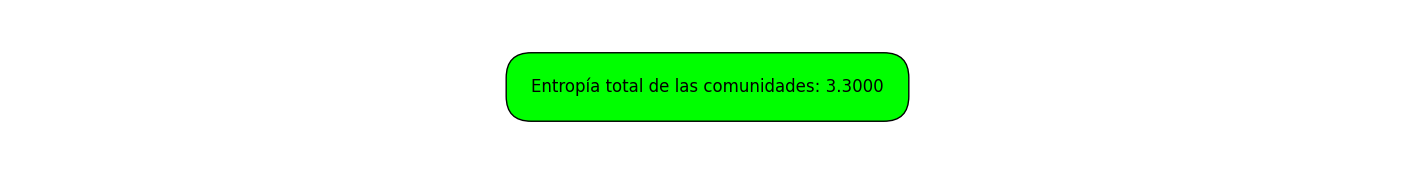

In [248]:
fig, axs = plt.subplots(1, 1, figsize=(18, 2))

sizes = np.array(lista_num_nodos)
proportions = sizes / G.number_of_nodes()
entropy = -np.sum(proportions * np.log2(proportions))
axs.axis('off')
axs.text(0.5, 0.5, f'Entropía total de las comunidades: {entropy:.4f}', color='black',
            horizontalalignment='center', verticalalignment='center', fontsize=12,
            bbox=dict(facecolor='lime', edgecolor='black', boxstyle='round,pad=1.5'))

plt.show()

## **4. Nodos centrales / Medidas macro**

### **Nodos por centralidad**

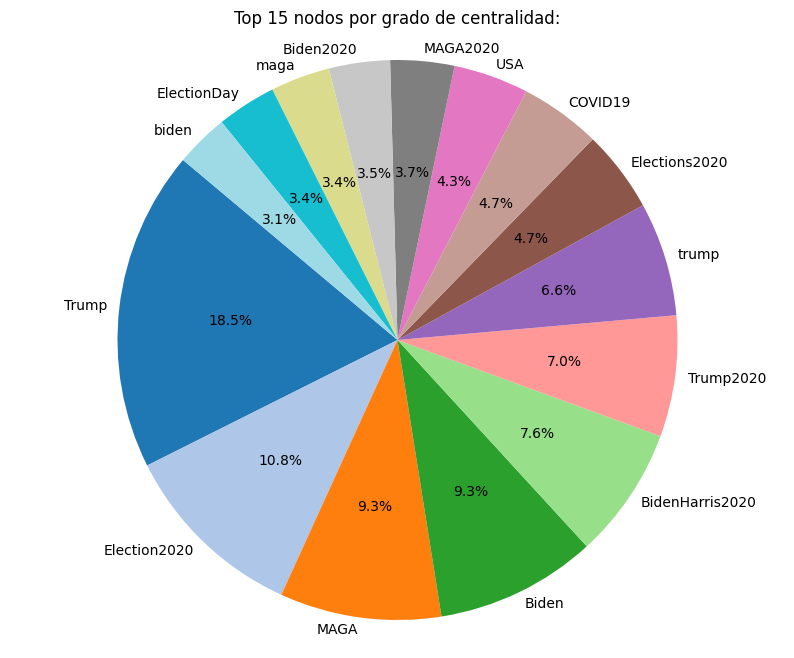

In [206]:
top_n = 15
degrees = nx.degree(G)
degrees = dict(sorted(dict(degrees).items(), key=lambda item: item[1], reverse=True)[:top_n])
degree_keys, degree_values = list(degrees.keys()), list(degrees.values())

degree_centrality = nx.degree_centrality(G)
degree_centrality = dict(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:top_n])
degree_c_keys, degree_c_values = list(degree_centrality.keys()), list(degree_centrality.values())
# Normalize the degree values to percentages
total_degree = sum(degree_values)
degree_percentages = [value / total_degree * 100 for value in degree_values]

node_colors = plt.cm.get_cmap("tab20")(np.linspace(0, 1, len(degree_keys)))
# ----------------------------------
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(degree_percentages, labels=degree_keys, colors=node_colors, autopct='%1.1f%%', startangle=140)

# label position´s offset
offset=0.95
for text in texts:
    text.set_position((text.get_position()[0] * offset, text.get_position()[1] * offset))

plt.title(f"Top {top_n} nodos por grado de centralidad:")
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

### **Medidas macro**

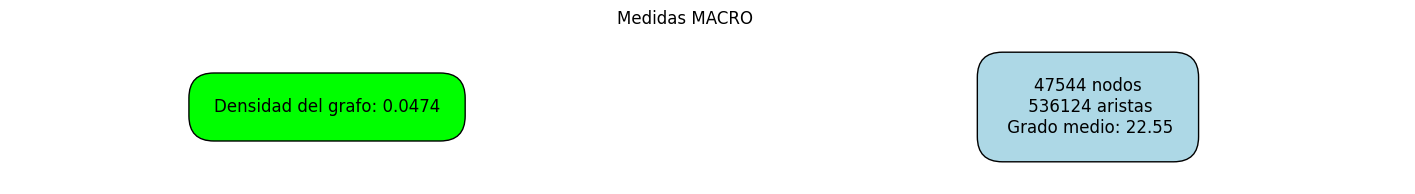

In [229]:
fig, axs = plt.subplots(1, 2, figsize=(18, 2))
plt.suptitle("Medidas MACRO")

graph_density = nx.density(G)
axs[0].axis('off')
axs[0].text(0.5, 0.5, f'Densidad del grafo: {graph_density*100:.4f}', color='black',
            horizontalalignment='center', verticalalignment='center', fontsize=12,
            bbox=dict(facecolor='lime', edgecolor='black', boxstyle='round,pad=1.5'))
# ----------------------------------
nodos = G.number_of_nodes()
ejes = G.number_of_edges()
k = ejes * 2 / nodos
axs[1].axis('off')
axs[1].text(0.5, 0.5, f'{nodos} nodos\n {ejes} aristas\n Grado medio: {k:.2f}', color='black',
            horizontalalignment='center', verticalalignment='center', fontsize=12,
            bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=1.5'))
# ----------------------------------

plt.show()

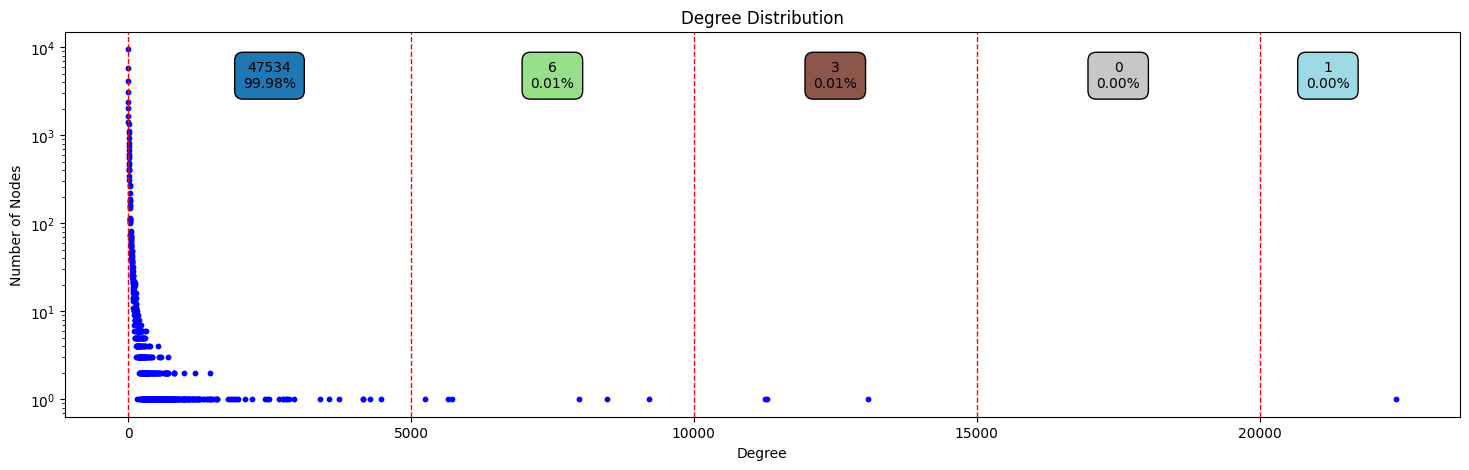

In [322]:
def count_values_in_range(sorted_list, range_start, range_end):
    start_index = bisect.bisect_left(sorted_list, range_start)
    end_index = bisect.bisect_right(sorted_list, range_end)
    return end_index - start_index
# ----------------------------------------------
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degree_count = np.bincount(degree_sequence)
degrees = np.arange(len(degree_count))
checkpoints = list(range(0, max(degrees), 5000))
checkpoints.append(max(degrees))

total_nodes = G.number_of_nodes()
plt.figure(figsize=(18, 5))
plt.scatter(degrees, degree_count, color='b', s=10) 

colors = plt.cm.get_cmap("tab20", len(checkpoints) - 1)
for i in range(len(checkpoints)-1):
    plt.axvline(x=checkpoints[i], color='r', linestyle='--', linewidth=1)
    count = count_values_in_range(degree_sequence[::-1], checkpoints[i], checkpoints[i+1])
    percentage = (count / total_nodes) * 100
    color = colors(i)  # directly assign a different color to each slot
    plt.text(checkpoints[i] + (checkpoints[i+1] - checkpoints[i]) / 2, max(degree_count) * 0.5, f'{count}\n{percentage:.2f}%', 
             ha='center', va='center', fontsize=10, bbox=dict(facecolor=color, edgecolor='black', boxstyle='round,pad=0.6'))

plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.yscale("log")  # Use logarithmic scale for better visualization
plt.show()

## **5. BLA**